## Lecture 21: Parsing HTML

### STA 141B

- HTML is short for hypertext markup language
- descriptive, markup language
- used for modifying text with hidden tags
- browser reads the html file, with the tags and everything and turns it into text with different fonts, colors, structure, etc
- html has head (metadata, style, scripts) and body (main content to be displayed)
- just html will look outdated: http://anson.ucdavis.edu/~affarris/

### Tags
&lt;TAG NAME&gt;STUFF BETWEEN TAGS&lt;\TAG NAME&gt;

- paragraph: &lt;p&gt;&lt;\p&gt;
- bold: &lt;strong&gt; text, create hyperlinks &lt;a href="site.html"&gt;
- create headers: &lt;h1&gt;&lt;h2&gt;
- create unordered lists: &lt;ul&gt;
- tables: &lt;table&gt;
- newline: &lt;br&gt;
- display image: &lt;img&gt;

### Style

- HTML only gives semantic structure to text, and does not specify or customize how these tags are visually represented
- CSS defines the visual meaning of the HTML, which is given in separate stylesheet files

```
.page-header {
  padding: 2rem 6rem; }
```

- tag.class selectors : select every tag with class
- tag#id selectors : the tag with id

### HTML structure

Tags such as `div, a, body, span` wrap more html with opening and closing tags 

```
<div class='example'>text in between</div>;
```

- hierarchical document structure
- If a tag is nested inside of another tag then it is the child (`<a>` is the child of `<p>`)
```
<p>Have you tried the <a href="salmon.html">salmon</a></p>
```
- tree structure is called the Document Object Model (DOM)
- LXML and BeautifulSoup parses the html string into this tree structure

## Breaking down data.gov climate data

Data.gov maintains a list of climate related datasets, but they are maintained by different agencies.  I'd like to get a sense of the number and diversity of these datasets, and which agencies they are coming from.

In [1]:
import requests
import requests_ftp
import requests_cache
import lxml
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
plt.style.use('ggplot')
requests_cache.install_cache('coll_cache')
%matplotlib inline

I went to data.gov and selected the climate data tab.  Here is the url: https://catalog.data.gov/dataset?groups=climate5434&page=1

Let's make a request for this page.

In [2]:
urlbase = "https://catalog.data.gov/dataset"
dataparams = {"groups":"climate5434","page":1}
climreq = requests.get(urlbase,params = dataparams)

In [3]:
climreq.url

'https://catalog.data.gov/dataset?groups=climate5434&page=1'

In [4]:
climhtml = climreq.text
clim = BeautifulSoup(climhtml,'lxml')

Here we imported the climate data catalogue (page 1), and turned it into a Beautiful Soup object.  We used the lxml parser, which is why we had to import lxml.  Let's look at the raw html.

In [5]:
print(climhtml[:500])

<!DOCTYPE html>
<!--[if IE 9]> <html lang="en" class="ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html lang="en"> <!--<![endif]-->
  <head>
    <link rel="stylesheet" type="text/css" href="/fanstatic/vendor/:version:2021-11-17T06:50:23.43/select2/select2.min.css" />
<link rel="stylesheet" type="text/css" href="/fanstatic/css/:version:2021-11-17T06:50:23.40/main.min.css" />
<link rel="stylesheet" type="text/css" href="/fanstatic/vendor/:version:2021-11-17T06:50:23.43/font-awesome/css/font-awesome.


The BS object, and tags have other tags within then that you can access either as a class object (like below) or using the find method

In [6]:
clim.body

<body data-locale-root="https://catalog.data.gov/" data-site-root="https://catalog.data.gov/">
<div class="sr-only sr-only-focusable"><a href="#content">Skip to content</a></div>
<a class="hide" href="#content">Skip to content</a>
<header class="navbar navbar-static-top masthead">
<div class="container">
<div class="searchbox-row skip-navigation">
<div class="skip-link">
<a href="#">Jump to Content</a>
</div>
<div>
<form action="/dataset" class="search-form form-inline navbar-right navbar-nav" method="get" role="search">
<div class="input-group">
<label class="hide" for="search-header">Search for:</label>
<input class="search-field form-control" id="search-header" name="q" onblur="if(value=='') value = 'Search Data.Gov'" onfocus="if(value=='Search Data.Gov') value = ''" placeholder="Search Data.Gov" type="search" value="Search Data.Gov"/> <span class="input-group-btn">
<button class="search-submit btn_new btn-default" type="submit">
<i class="fa fa-search"></i>
<span class="sr-only">Se

In [7]:
collset_content = clim.find_all(name='div',attrs={'class':'dataset-content'})
collset1 = collset_content[0]
print(collset1.prettify())

<div class="dataset-content">
 <div class="organization-type-wrap">
  <span class="organization-type" data-organization-type="federal" title="Federal Government">
   <span>
    Federal
   </span>
  </span>
 </div>
 <h3 class="dataset-heading">
  <a href="/dataset/aster-global-digital-elevation-model-v003">
   ASTER Global Digital Elevation Model V003
  </a>
 </h3>
 <div class="notes">
  <p class="dataset-organization">
   National Aeronautics and Space Administration —
  </p>
  <div>
   The ASTER Global Digital Elevation Model (GDEM) Version 3 (ASTGTM) provides a global digital elevation model (DEM) of land areas on Earth at a spatial resolution of...
  </div>
 </div>
 <ul class="dataset-resources unstyled">
  <li>
   <a class="label label-default" data-format="html" data-organization="National Aeronautics and Space Administration" href="https://scholar.google.com/scholar?q=10.5067%2FASTER%2FASTGTM.003" target="_blank">
    HTML
   </a>
  </li>
  <li>
   <a class="label label-default" 

In [8]:
collset1.name, collset1.attrs, collset1['class']

('div', {'class': ['dataset-content']}, ['dataset-content'])

In [9]:
aset1 = collset1.find_all('a')
print(aset1[0])
print(aset1[1])

<a href="/dataset/aster-global-digital-elevation-model-v003">ASTER Global Digital Elevation Model V003</a>
<a class="label label-default" data-format="html" data-organization="National Aeronautics and Space Administration" href="https://scholar.google.com/scholar?q=10.5067%2FASTER%2FASTGTM.003" target="_blank">HTML</a>


Here is the title of the dataset collection, let's make a script to extract the title and href's from the 'a' tags.

In [10]:
aset1[0].text

'ASTER Global Digital Elevation Model V003'

In [11]:
aset1[0].attrs

{'href': '/dataset/aster-global-digital-elevation-model-v003'}

In [12]:
adict = {'label':[],'coll':[],'more':[]}
for a in aset1:
    try:
        adict[a['class'][0]].append(a['href'])
    except KeyError:
        adict['coll'].append(a['href'])
        collname = a.text.strip()

In [13]:
collname

'ASTER Global Digital Elevation Model V003'

In [14]:
adict

{'label': ['https://scholar.google.com/scholar?q=10.5067%2FASTER%2FASTGTM.003',
  'https://doi.org/10.5067/ASTER/ASTGTM.003',
  'https://lpdaac.usgs.gov',
  'http://asterweb.jpl.nasa.gov/',
  'https://search.earthdata.nasa.gov/search?q=C1575726572-LPDAAC_ECS',
  'https://lpdaac.usgs.gov/documents/434/ASTGTM_User_Guide_V3.pdf'],
 'coll': ['/dataset/aster-global-digital-elevation-model-v003'],
 'more': ['/dataset/aster-global-digital-elevation-model-v003']}

We are also able to get the description component of the collection.

In [15]:
collnotes = collset1.find('div',attrs={'class':'notes'})

In [16]:
print(collnotes.prettify())

<div class="notes">
 <p class="dataset-organization">
  National Aeronautics and Space Administration —
 </p>
 <div>
  The ASTER Global Digital Elevation Model (GDEM) Version 3 (ASTGTM) provides a global digital elevation model (DEM) of land areas on Earth at a spatial resolution of...
 </div>
</div>



In [17]:
collnotes.p.text.strip()

'National Aeronautics and Space Administration —'

In [18]:
collnotes.div.text.strip()

'The ASTER Global Digital Elevation Model (GDEM) Version 3 (ASTGTM) provides a global digital elevation model (DEM) of land areas on Earth at a spatial resolution of...'

In [19]:
collorg = collnotes.p.text.strip()
colldesc = collnotes.div.text.strip()

Now that we have some code to process the collection html, let's create a def to modularize this section.

In [20]:
def process_collset(collset1):
    """
    Processes the data.gov html within the tags <div class = dataset-content>...
    Input: html string
    Output: tuple of title (string), organization (string), 
      description (string), hrefs (dictionary)
    """
    aset1 = collset1.find_all('a')
    adict = {'label':[],'coll':[],'more':[]}
    for a in aset1:
        try:
            adict[a['class'][0]].append(a['href'])
        except KeyError:
            adict['coll'].append(a['href'])
            collname = a.text.strip()
    collnotes = collset1.find('div',attrs={'class':'notes'})
    collorg = collnotes.p.text.strip()
    colldescdiv = collnotes.div
    if colldescdiv:
        colldesc = colldescdiv.text.strip()
    else:
        colldesc = ""
    return collname, collorg, colldesc, adict

In [21]:
help(process_collset)

Help on function process_collset in module __main__:

process_collset(collset1)
    Processes the data.gov html within the tags <div class = dataset-content>...
    Input: html string
    Output: tuple of title (string), organization (string), 
      description (string), hrefs (dictionary)



In [22]:
collname, collorg, colldesc, adict = process_collset(collset1)

In [23]:
collname

'ASTER Global Digital Elevation Model V003'

In [24]:
collorg

'National Aeronautics and Space Administration —'

In [25]:
colldesc

'The ASTER Global Digital Elevation Model (GDEM) Version 3 (ASTGTM) provides a global digital elevation model (DEM) of land areas on Earth at a spatial resolution of...'

In [26]:
adict

{'label': ['https://scholar.google.com/scholar?q=10.5067%2FASTER%2FASTGTM.003',
  'https://doi.org/10.5067/ASTER/ASTGTM.003',
  'https://lpdaac.usgs.gov',
  'http://asterweb.jpl.nasa.gov/',
  'https://search.earthdata.nasa.gov/search?q=C1575726572-LPDAAC_ECS',
  'https://lpdaac.usgs.gov/documents/434/ASTGTM_User_Guide_V3.pdf'],
 'coll': ['/dataset/aster-global-digital-elevation-model-v003'],
 'more': ['/dataset/aster-global-digital-elevation-model-v003']}

In [27]:
for collset in collset_content:
    collname = process_collset(collset)[0]
    print(collname)

ASTER Global Digital Elevation Model V003
MODIS/Aqua Near Real Time (NRT) Sea Ice Extent 5-Min L2 Swath 1km
MODIS/Terra+Aqua L3 Value-added Aerosol Optical Depth - NRT
NLDAS Mosaic Land Surface Model L4 Hourly 0.125 x 0.125 degree V002 (NLDAS_MOS0125_H) at GES DISC
Near-Real-Time SSM/I EASE-Grid Daily Global Ice Concentration and Snow Extent V002
NLDAS Secondary Forcing Data L4 Monthly 0.125 x 0.125 degree V002 (NLDAS_FORB0125_M) at GES DISC
NLDAS Secondary Forcing Data L4 Monthly Climatology 0.125 x 0.125 degree V002 (NLDAS_FORB0125_MC) at GES DISC
IceBridge Ku-Band Radar L1B Geolocated Radar Echo Strength Profiles V002
IceBridge CAMBOT L1B Geolocated Images V001
IceBridge Narrow Swath ATM L1B Elevation and Return Strength V002
NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 3
IceBridge Radar L3 Tomographic Ice Thickness V002
IceBridge Riegl Laser Altimeter L1B Time-Tagged Laser Ranges V001
IceBridge Scintrex CS-3 Cesium Magnetometer L1B Geolocated M

Let's modularize the queries from data.gov.

In [28]:
def clim_page(urlbase = "https://catalog.data.gov/dataset", groups="climate5434",
              page=1):
    """
    Queries the data.gov climate change data search for a specific page
    Input: urlbase, groups, page (strings)
    Output: list of dataset-content 
    """
    dataparams = {"groups":groups,"page":page}
    climreq = requests.get(urlbase,params = dataparams)
    clim_bs = BeautifulSoup(climreq.text,'lxml')
    collset_content = clim_bs.find_all(name='div',attrs={'class':'dataset-content'})
    return collset_content

In [29]:
clim = clim_page(page=2)

In [30]:
print([process_collset(c)[0] for c in clim])

['GLDAS Noah Land Surface Model L4 monthly 0.25 x 0.25 degree V2.0 (GLDAS_NOAH025_M) at GES DISC', 'Global Fire Emissions Database, Version 4.1 (GFEDv4)', 'Global Annual Freezing and Thawing Indices, Version 1', 'MyPyramid Food Raw Data', 'Production, Supply, and Distribution Database', 'Global Agricultural Information Network', 'IceBridge LVIS L0 Raw Ranges V001', 'NLDAS Forcing Data L4 Monthly 0.125 x 0.125 degree V001 (NLDAS_FOR0125_M) at GES DISC', 'NLDAS Secondary Forcing Data L4 Hourly 0.125 x 0.125 degree V002 (NLDAS_FORB0125_H) at GES DISC', 'IceBridge Sander AIRGrav L1B Geolocated Free Air Gravity Anomalies V001', 'IceBridge LVIS L1B Geolocated Return Energy Waveforms V002', 'IceBridge NSERC L1B Geolocated Meteorologic and Surface Temperature Data, Version 1', 'IceBridge MCoRDS L3 Gridded Ice Thickness, Surface, and Bottom V002', 'Historical Arctic and Antarctic Surface Observational Data, Version 1', 'AMSRIce03 Sea Ice Thickness Data, Version 1', 'Tropospheric Emission Spectr

Here we extract all of the pages from the climate group from data.gov.

In [31]:
page_num_max = 34
climate_colls = []
for page_num in range(1,page_num_max+1):
    try:
        clim = clim_page(page=page_num)
        if clim != None:
            climate_colls += [process_collset(c) for c in clim]
        else:
            break
    except requests.HTTPError:
        break

In [32]:
len(climate_colls)

401

In [33]:
climate_colls[0][3]

{'label': ['https://scholar.google.com/scholar?q=10.5067%2FASTER%2FASTGTM.003',
  'https://doi.org/10.5067/ASTER/ASTGTM.003',
  'https://lpdaac.usgs.gov',
  'http://asterweb.jpl.nasa.gov/',
  'https://search.earthdata.nasa.gov/search?q=C1575726572-LPDAAC_ECS',
  'https://lpdaac.usgs.gov/documents/434/ASTGTM_User_Guide_V3.pdf'],
 'coll': ['/dataset/aster-global-digital-elevation-model-v003'],
 'more': ['/dataset/aster-global-digital-elevation-model-v003']}

I'll build a dataframe so that I can count the data collections by organization.

In [34]:
climate_df = pd.DataFrame({'name':c[0],'organization':c[1],'description':c[2]}
                          for c in climate_colls)

In [35]:
climate_df

,name,organization,description
0,ASTER Global Digital Elevation Model V003,National Aeronautics and Space Administration —,The ASTER Global Digital Elevation Model (GDEM...
1,MODIS/Aqua Near Real Time (NRT) Sea Ice Extent...,National Aeronautics and Space Administration —,MODIS Near Real Time (NRT) Sea Ice Extent 5-Mi...
2,MODIS/Terra+Aqua L3 Value-added Aerosol Optica...,National Aeronautics and Space Administration —,MODIS was launched aboard the Terra satellite ...
3,NLDAS Mosaic Land Surface Model L4 Hourly 0.12...,National Aeronautics and Space Administration —,This data set contains a series of land surfac...
4,Near-Real-Time SSM/I EASE-Grid Daily Global Ic...,National Aeronautics and Space Administration —,The Near-real-time Ice and Snow Extent (NISE) ...
...,...,...,...
396,Travel Monitoring Analysis System (TMAS) (Nati...,Department of Transportation —,The Travel Monitoring Analysis System (TMAS) d...
397,Intermodal Passenger Connectivity Database (IP...,Department of Transportation —,"The IPCD is November 4, 2019 and is a nationwi..."
398,Navigable Waterway Nodes (National) - National...,Department of Transportation —,The Navigable Waterway Nodes dataset is June 2...
399,Ports (National) - National Geospatial Data As...,Department of Transportation —,"The Ports dataset June 26, 2019 is part of the..."


In [36]:
org_count = climate_df.groupby('organization').count()

In [37]:
org_count.sort_values(by='name',ascending=False)

,name,description
organization,,
National Aeronautics and Space Administration —,131,131
Department of Agriculture —,61,61
U.S. Environmental Protection Agency —,60,60
"National Oceanic and Atmospheric Administration, Department of Commerce —",32,32
U.S. Department of Health & Human Services —,27,27
Department of Transportation —,25,25
Department of Energy —,14,14
Department of Commerce —,13,13
Federal Geographic Data Committee —,10,10


In [38]:
org_count_abbr = org_count[org_count['name'] > 20]

In [39]:
rem_count = org_count[org_count['name'] <= 20].sum()[0]

In [40]:
type(rem_count)

numpy.int64

In [41]:
org_count_abbr = org_count_abbr.append(pd.DataFrame({'name':[rem_count]}, 
                                                    index=['Other']))
org_count_abbr = org_count_abbr[['name']].rename(columns={'name':'count'})

In [42]:
org_count_abbr

,count
Department of Agriculture —,61
Department of Transportation —,25
National Aeronautics and Space Administration —,131
"National Oceanic and Atmospheric Administration, Department of Commerce —",32
U.S. Department of Health & Human Services —,27
U.S. Environmental Protection Agency —,60
Other,65


<Figure size 720x576 with 0 Axes>

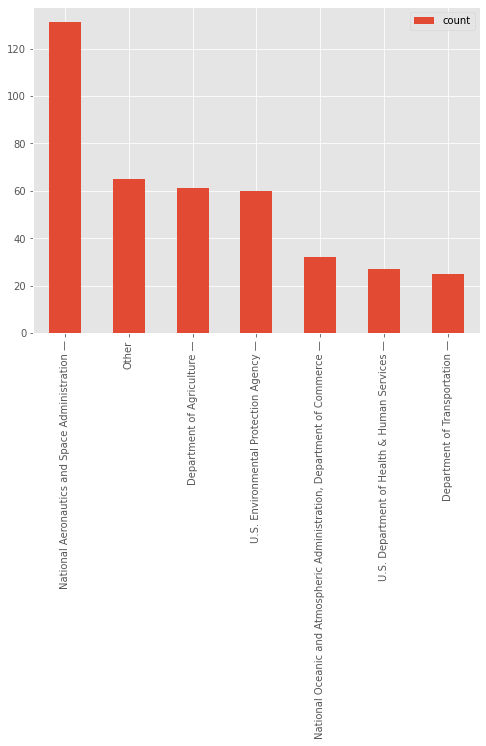

In [43]:
plt.figure(figsize=(10,8))
_ = org_count_abbr.sort_values(by='count',ascending=False).plot(y='count',kind='bar',figsize=(8,6))

In [44]:
org_sorted = org_count_abbr.sort_values(by='count',ascending=False).index.values

# Tracking the status of datasets

The goal of this section is to look at the status of the datasets, and if they are able to be downloaded by following the link.  We can do this by checking the header for a http or ftp request.  Let's make some defs to query the dataset urls.  The first is for converting relative paths to urls, and the second returns the status of the request to that url.

In [45]:
def reltoabs(url,urlbase = "https://catalog.data.gov"):
    """
    Input: url string
    Output: url string
    """
    if url[0]=='/':
        return urlbase+url
    if (url[:6] == "http:/") and (not url[6] == "/"):
        return "http://" + url[6:]
    return url

In [46]:
def testurl(url):
    """
    Input: url
    Output: request status code
    """
    try:
        if url[:4] == 'http':
            r = requests.head(url)
            return r.status_code
        if url[:3] == 'ftp':
            requests_ftp.monkeypatch_session()
            s = requests.Session()
            resp = s.list(url)
            return resp.status_code
    except requests.ConnectionError:
        return None

In [47]:
[a for a in climate_colls[0][3]['label']]

['https://scholar.google.com/scholar?q=10.5067%2FASTER%2FASTGTM.003',
 'https://doi.org/10.5067/ASTER/ASTGTM.003',
 'https://lpdaac.usgs.gov',
 'http://asterweb.jpl.nasa.gov/',
 'https://search.earthdata.nasa.gov/search?q=C1575726572-LPDAAC_ECS',
 'https://lpdaac.usgs.gov/documents/434/ASTGTM_User_Guide_V3.pdf']

In [48]:
urlstats=[]
errors = []
for coll in climate_colls:
    urlstattemp = []
    for urlrel in coll[3]['label']:
        try:
            url = reltoabs(urlrel)
            urlstatus = testurl(url)
            urlstattemp += [urlstatus]
        except BaseException as e:
            print(urlrel)
            errors.append((e,urlrel))
    urlstats.append(urlstattemp)

ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02189/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02172/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02182/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G01358/
ftp://sidads.colorado.edu/DATASETS/NOAA/G02203/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02171/


In [49]:
len(errors)

6

In [50]:
errors[0]

(ValueError("invalid literal for int() with base 10: '226-Options:'"),
 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02189/')

In [51]:
len(urlstats)

401

We can see that urlstats contains the request status of the urls that are listed on data.gov.  So let's make a def that converts each list of status returns into a dict of counts of each type.  This way we can pass it to pd.DataFrame

In [52]:
urlstats[0:10]

[[200, 302, 200, None, 200, 200],
 [200, 200, 301, 200, 301],
 [200, 200, 301, 200],
 [200, 200, 301, 200, 200, 200],
 [200, 401, 200, 302],
 [200, 200, 301, 200, 200, 200],
 [200, 200, 301, 200, 200, 200],
 [200, 301, 401, 200, 301, 401],
 [200, 200, 401, 200, 200, 401],
 [200, 200, 401, 200, 302, 302],
 [200, 302, 302, 302],
 [200, 200, 401, 200, 302, 302],
 [200, 401, 200, 302, 302],
 [200, 301, 200, 302, 302],
 [200, 401, 200, 302, 200, 200],
 [200, 401, 401, 401, 401, 302],
 [200, 401, 401, 302, 302],
 [200, 401, 302, 302],
 [302],
 [200, 200, 301, 200, 200, 405],
 [200, 200, 301, 200, 200, 200],
 [200, 401, 200, 302, 200, 200],
 [200, 401, 302, 302],
 [302],
 [None],
 [None],
 [200, 200, 301, 200, 200, 301],
 [200, 200, 301, 302, 200, 200],
 [200, 200, 301, 200, 200, 200],
 [200, 301, 401, 200, 301, 401],
 [200, 200, 301, 200, 302, 302],
 [200, 401, 302, 302],
 [200, 301, 401, 301, 401, 301],
 [200, 401, 302, 302],
 [200, 401, 401, 302, 302],
 [301],
 [200, 200, 401, 200, 302, 30

In [53]:
def convstatnames(stats):
    """Return a dictionary of counts"""
    sdict = dict(Counter(stats))
    return {'status_'+str(a):b for a,b in sdict.items()}

stat_df = pd.DataFrame([convstatnames(stats) for stats in urlstats])
stat_df = stat_df.fillna(0)
stat_df.head()

failedstatus = ['status_400','status_404','status_405','status_503','status_None']
stat_df['failed ratio'] = stat_df[failedstatus].sum(axis=1)/stat_df.sum(axis=1)

We've also created a variable which is the proportion of urls that returned a status in the 400's or 500's or None.  Let's now join this against the climate_df to get one DataFrame of all unique combinations of failed ratio and organization.  Retain only the most common organizations.

In [54]:
climate_df = climate_df.join(stat_df)
climate_failed = climate_df.groupby(['organization','failed ratio'])
failed_count = climate_failed.count()[['name']].rename(columns={'name':'count'})
failed_count = failed_count.reset_index()
red_orgs = org_count[org_count['name'] > 20].index
failed_count_red = failed_count[[org in red_orgs for org in failed_count['organization']]]
failed_count_red.head()

,organization,failed ratio,count
1,Department of Agriculture —,0.000000,56
2,Department of Agriculture —,0.333333,1
3,Department of Agriculture —,0.500000,1
4,Department of Agriculture —,1.000000,3
17,Department of Transportation —,0.000000,20


In [55]:
climate_df.head()

,name,organization,description,status_200,status_302,status_None,status_301,status_401,status_405,status_404,status_400,status_403,status_307,status_226,status_503,failed ratio
0,ASTER Global Digital Elevation Model V003,National Aeronautics and Space Administration —,The ASTER Global Digital Elevation Model (GDEM...,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667
1,MODIS/Aqua Near Real Time (NRT) Sea Ice Extent...,National Aeronautics and Space Administration —,MODIS Near Real Time (NRT) Sea Ice Extent 5-Mi...,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,MODIS/Terra+Aqua L3 Value-added Aerosol Optica...,National Aeronautics and Space Administration —,MODIS was launched aboard the Terra satellite ...,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,NLDAS Mosaic Land Surface Model L4 Hourly 0.12...,National Aeronautics and Space Administration —,This data set contains a series of land surfac...,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,Near-Real-Time SSM/I EASE-Grid Daily Global Ic...,National Aeronautics and Space Administration —,The Near-real-time Ice and Snow Extent (NISE) ...,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [56]:
org_numbers = {org_sorted[i]:i+1 for i in range(len(org_sorted))}
failed_count_red['org number'] = failed_count_red['organization'].apply(lambda o: org_numbers[o])

/tmp/ipykernel_73749/3929521048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_count_red['org number'] = failed_count_red['organization'].apply(lambda o: org_numbers[o])


In [57]:
failed_count_red.head()

,organization,failed ratio,count,org number
1,Department of Agriculture —,0.000000,56,3
2,Department of Agriculture —,0.333333,1,3
3,Department of Agriculture —,0.500000,1,3
4,Department of Agriculture —,1.000000,3,3
17,Department of Transportation —,0.000000,20,7


In [58]:
failed_count_red.head()

,organization,failed ratio,count,org number
1,Department of Agriculture —,0.000000,56,3
2,Department of Agriculture —,0.333333,1,3
3,Department of Agriculture —,0.500000,1,3
4,Department of Agriculture —,1.000000,3,3
17,Department of Transportation —,0.000000,20,7


1: National Aeronautics and Space Administration —
2: Other
3: Department of Agriculture —
4: U.S. Environmental Protection Agency —
5: National Oceanic and Atmospheric Administration, Department of Commerce —
6: U.S. Department of Health & Human Services —
7: Department of Transportation —


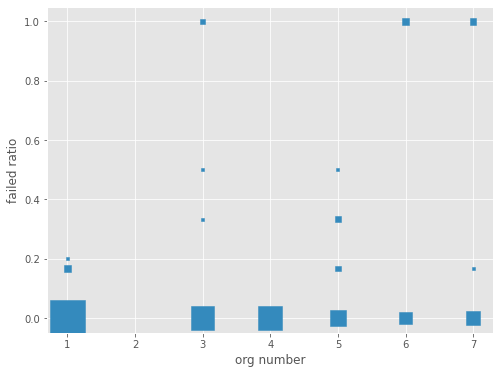

In [61]:
from operator import itemgetter
norgs=len(org_numbers)
_ = failed_count_red.plot(x = 'org number',y = 'failed ratio',xticks=range(1,norgs+1),
                      s=failed_count_red['count']*10,kind='scatter',marker='s',figsize=(8,6))
for orgname,i in sorted(org_numbers.items(),key=itemgetter(1)):
    print("{}: {}".format(i,orgname))